In [90]:
from ncbiumls.authorization import authorization
from ncbiumls.access import UMLS, CUI
from time import sleep
from lxml import html
import pandas as pd
import requests
import json
import copy
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
NORMAL_NUM = False
data = {}

# Read data from json
for i in os.listdir('json/'):
    if i.startswith('1') or i.startswith('2'):
        print(i)
        year = int(i.split('.')[0])
        with open('json/{}'.format(i)) as data_file:
            data[year] = json.load(data_file)
            if NORMAL_NUM:
                for ttype in ['chemicals', 'mesh_titles']:
                    for key, val in data[year][ttype].items():
                        data[year][ttype][key] = val/data[year]['count_articles']
print('Done!')

1990.json
1991.json
1992.json
1993.json
1994.json
1995.json
1996.json
1997.json
1998.json
1999.json
2000.json
2001.json
2002.json
2003.json
2004.json
2005.json
2006.json
2007.json
2008.json
2009.json
2010.json
2011.json
2012.json
2013.json
2014.json
2015.json
2016.json
2017.json
Done!


In [22]:
def get_sorted(p_dict):
    return sorted(p_dict.items(), key=lambda x: x[1], reverse=True)

def dump_csv(p_dict, filename):
    to_print = []
    for y in range(1990, 2018):
        tmp = get_sorted(p_dict[y]['chemicals'])
        for word, freq in tmp:
            for n in range(freq):
                to_print.append(word)

    with open(filename, 'w') as ff:
        ff.write('; '.join(list(map(lambda x: x.replace(' ', '_'), to_print))))
        
def dump_csv_freq(p_dict, filename):
    to_print = []

    for y in [2000, 2005, 2015]:
        tmp = get_sorted(p_dict[y]['chemicals'])
        for word, freq in tmp:
                to_print.append(word.replace(' ', '_').replace(',','_'))
                to_print.append('; ')
                to_print.append(str(freq))
                to_print.append('\n')

    with open(filename, 'w') as ff:
        ff.write(''.join(to_print))
        
# Sum of terms per year during 27 years
def count_terms():
    res = 0

    for y in range(1990, 2018):
        res += len(data[y]['chemicals'].items()) + len(data[y]['mesh_titles'].items())

    return res

In [25]:
def dump_topn_mesh_titles(p_dict, filename, n=100):
    assert(n <= len(p_dict))
    with open(filename, 'w') as f:
        f.write('\n'.join(list(map(lambda x: x[0], get_sorted(p_dict['mesh_titles'])[:n]))))
        
def dump_topn_chems(p_dict, filename, n=100):
    assert(n <= len(p_dict))
    with open(filename, 'w') as f:
        f.write('\n'.join(list(map(lambda x: x[0], get_sorted(p_dict['chemicals'])[:n]))))
        
def get_topn_terms(p_dict, n=100):
    """
    pdict - data[2009]['mesh_titles']
    """
    return list(map(lambda x: x[0], get_sorted(p_dict)[:100]))

def draw_articles_plot(p_dict):
    to_draw = []
    inxs = []

    for i in range(1990, 2016):
        if i in p_dict:
            tmp = p_dict[i]['count_articles']
            to_draw.append(tmp)
            inxs.append(i)

    plt.figure()
    plt.scatter(inxs, to_draw)
    plt.title('Number of Articles per year')
    plt.show()
    
def draw_plot(term, save=''):
    to_draw = []
    inxs = []

    for i in range(1990, 2016):
        if i in data and term in data[i]['chemicals']:
            tmp = data[i]['chemicals'][term]
            to_draw.append(tmp)
            inxs.append(i)

    plt.figure()
    plt.title(term)
    plt.scatter(inxs, to_draw)
    if save != '':
        plt.savefig(save)

In [22]:
top100_mt = get_topn_terms(data[2009]['mesh_titles'])
top200_chem = get_topn_terms(data[2009]['chemicals'], n=200)

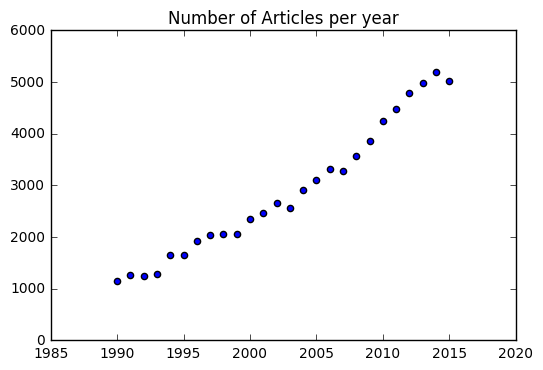

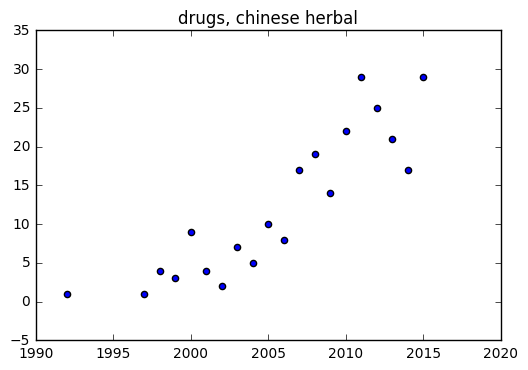

In [123]:
draw_articles_plot(data)
draw_plot('drugs, chinese herbal', 'ch_herbal.png')

In [202]:
def get_df(filename):
    df = pd.read_csv(filename, sep=';', header=None)
    df = df.dropna()
    return df

def get_dict_of_topn(df, n=12):
    tmpdf = df.groupby(0).head(n)
    dict_of_topn = {}
    for y,inst in zip(tmpdf.reset_index(drop=True)[0].values, tmpdf.reset_index(drop=True)[1].values):
        if int(y) not in dict_of_topn:
            dict_of_topn[int(y)] = []
        dict_of_topn[int(y)].append(inst)
    return dict_of_topn

def replaced(input_data, replace_list):
    p_data = copy.deepcopy(input_data)
    for from_term, to_term in replace_list:
        for y in range(1990, 2018):
            if from_term in p_data[y]['mesh_titles'] and to_term in p_data[y]['mesh_titles']:
                p_data[y]['mesh_titles'][to_term] += p_data[y]['mesh_titles'][from_term]
                p_data[y]['mesh_titles'].pop(from_term)
            if from_term in p_data[y]['chemicals'] and to_term in p_data[y]['chemicals']:
                p_data[y]['chemicals'][to_term] += p_data[y]['chemicals'][from_term]
                p_data[y]['chemicals'].pop(from_term)
    return p_data

df = get_df('output_cleaned.csv')
df

,0,1,2,3
0,1990.0,amyloid beta-protein precursor,0.054783,"['Amino Acid, Peptide, or Protein']"
1,1990.0,tacrine,0.017391,-
2,1990.0,acetylcholinesterase,0.016522,"['Amino Acid, Peptide, or Protein', 'Enzyme', ..."
3,1990.0,aluminum,0.015652,-
4,1990.0,physostigmine,0.010435,-
5,1990.0,hydrocortisone,0.009565,-
6,1990.0,acetylcholine,0.009565,"['Organic Chemical', 'Biologically Active Subs..."
7,1990.0,dopamine,0.007826,-
8,1990.0,hydroxyindoleacetic acid,0.007826,-
9,1990.0,choline,0.006957,-


In [203]:
term_list = ['presenilin-1', 'presenilin-2', 'amyloid beta-protein precursor']
for y in range(1996, 2018):
    for term in term_list:
        ind_list = df[(y == df[0]) & (term == df[1])].index.tolist()
        assert(len(ind_list) < 3)
        if len(ind_list) == 2:
            ind1 = ind_list[0]
            ind2 = ind_list[1]
            add_value = df.ix[ind1].tolist()[2]
            old_value = df.ix[ind1].tolist()[2]
            df = df.set_value(ind2, 2, old_value + add_value)
            df = df.drop(ind1)

In [204]:
# TODO: Replace terms in DataFrame
#
# df[(1997.0 == df[0]) & ('psen1 protein, human' == df[1])][0].tolist()[0] = 10
# df[(1997.0 == df[0]) & ('psen1 protein, human' == df[1])]
# df = df.set_value(325, 2, 100)
# df[(1996.0 == df[0]) & ('psen1 protein, human' == df[1])].index.tolist()
# 
df[(1996.0 == df[0]) & ('presenilin-1' == df[1])]

,0,1,2,3
246,1996.0,presenilin-1,0.07392,"['Amino Acid, Peptide, or Protein', 'Biologica..."


In [205]:
for y in [1990, 2000, 2010, 2015]:
    print("Year: {}".format(y))
    print('-----')
    for inst in get_dict_of_topn(df, n=3)[y]:
        print(inst)
    print('########')
    print()

Year: 1990
-----
amyloid beta-protein precursor
tacrine
acetylcholinesterase
########

Year: 2000
-----
amyloid beta-protein precursor
presenilin-1
apolipoprotein e4
########

Year: 2010
-----
amyloid beta-protein (1-42)
apolipoprotein e4
amyloid beta-protein (1-40)
########

Year: 2015
-----
amyloid beta-protein (1-42)
apolipoprotein e4
presenilin-1
########



In [206]:
# REPLACE:
# app protein, human --with--> amyloid beta-protein precursor
# psen1 protein, human --with--> presenilin-1
# psen2 protein, human --with--> presenilin-2

In [207]:
to_replace = [('app protein, human', 'amyloid beta-protein precursor'), \
              ('psen1 protein, human', 'presenilin-1'), \
              ('psen2 protein, human', 'presenilin-2')]

data = replaced(data, to_replace)

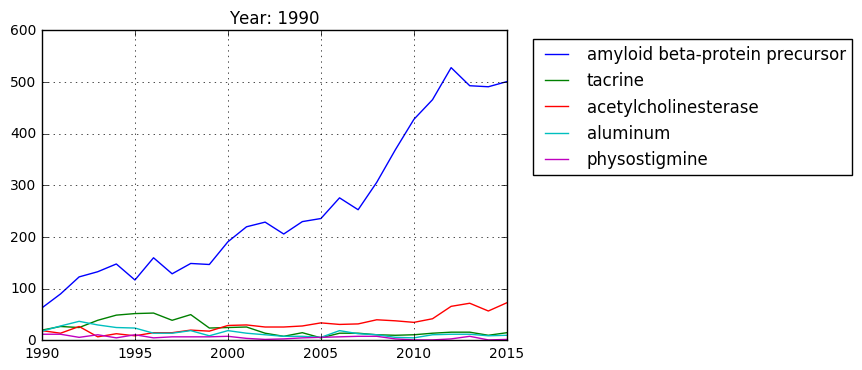

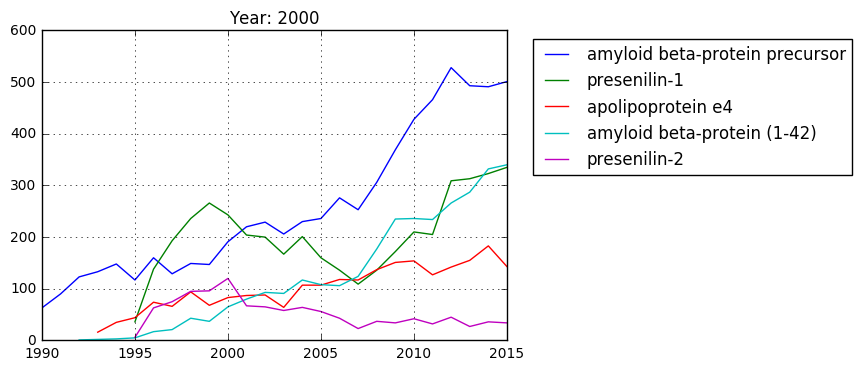

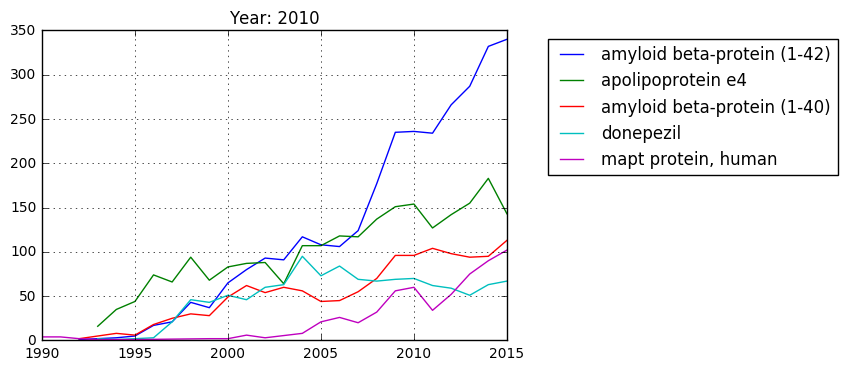

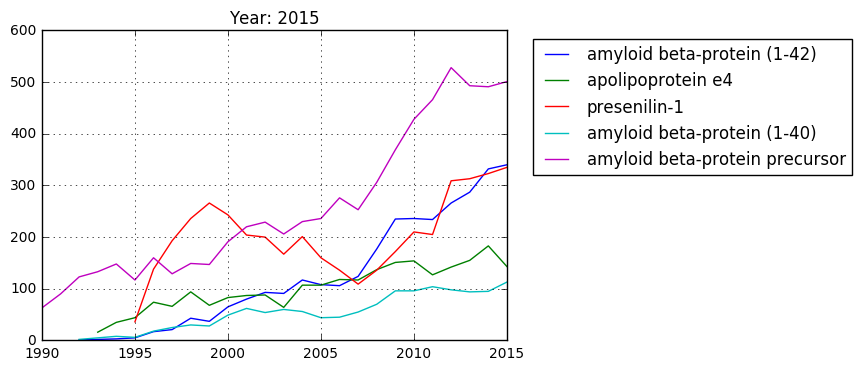

In [211]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'r--', 'g--', 'b--']

for y in [1990, 2000, 2010, 2015]:
    c = 0
    fig = plt.figure(1)
    for inst in get_dict_of_topn(df, n=5)[y]:        
        ax = fig.add_subplot(111)
        
        to_draw = []
        inxs = []
        for i in range(1990, 2016):
            if i in data and inst in data[i]['chemicals']:
                tmp = data[i]['chemicals'][inst]
                if inst == 'psen1 protein, human':
                    print(y,i,inst)
                to_draw.append(tmp)
                inxs.append(i)

        ax.plot(inxs, to_draw, colors[c], label=inst)
        c += 1


    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.4,1))

    ax.grid('on')    
    plt.title("Year: {}".format(y))
    # fig.savefig('year{}'.format(y), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

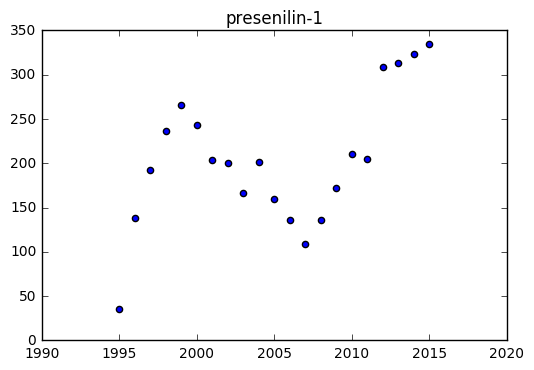

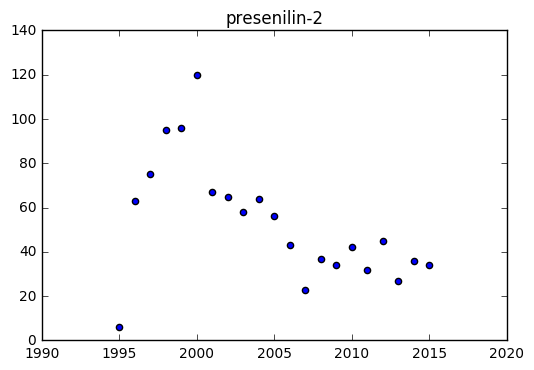

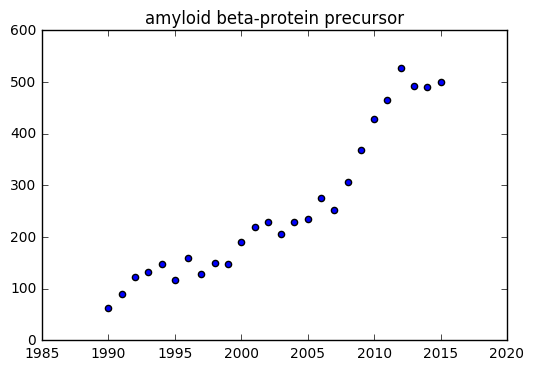

In [210]:
draw_plot('presenilin-1')
draw_plot('presenilin-2')
draw_plot('amyloid beta-protein precursor')

In [7]:
# Parsing from UMLS
data_umls = UMLS()

print(data_umls.getST())
print(data_umls.tgt.split('/')[-1])

ST-5549864-poeetudGLCvOjDfOu5jg-cas
TGT-3553061-GdtU4FACncJm3OhAMnd7eaeyaCgueldpkmszovud3ZDFGRXTQp-cas


In [286]:
top100_chem[12:15]

['amyloid beta-peptides',
 'peptide fragments',
 'amyloid beta-protein precursor']

In [12]:
def echo(p_dict, p_str):
    print('--> {}'.format(p_str))
    print(p_dict)
    print()

m_dict_ui_by_term = {} # term : ui
m_dict_term_by_ui = {} # ui : term

m_dict_sem_types_by_ui = {} # ui : [name1, name2, ...]
m_dict_uis_by_st = {} # sem_type : [ui1, ui2, ...]

m_dict_sem_types_by_term = {}
m_dict_term_by_st = {}

# for n, m_term in enumerate(top100_chem[12:]):
for n, m_term in enumerate(['proteins', 'mapt']):
# for m_term in top100_chem[61:63]:
    
    echo(m_term, 'TERM')
#     print(n, len(top100_chem[12:]))
    res = data_umls.askTerm(m_term, pageSize=100000, searchType='exact')
    print(res)

    if len(res) == 0:
        print('<empty>')
        continue
    
    for i in res:
        ui = i['ui']

        if m_term not in m_dict_ui_by_term:
            m_dict_ui_by_term[m_term] = []
        m_dict_ui_by_term[m_term].append(ui)

        if ui not in m_dict_term_by_ui:
            m_dict_term_by_ui[ui] = []
        m_dict_term_by_ui[ui].append(m_term)

    m_cui = CUI()

    print('---')
    print(m_dict_ui_by_term)
    print(m_term)
    print('+++')
    for ui in m_dict_ui_by_term[m_term]:
        query_res = m_cui.CUIGeneral(ui)
        
        term = m_dict_term_by_ui[ui][0]
        print('>>>')
        print(m_dict_term_by_ui)
        print(ui)
        print('<<<')
        
        if ui == 'C0611285':
            term = 'app protein, human'
        elif ui == 'C0027754':
            term = 'nerve growth factor'
        else: 
            assert(len(m_dict_term_by_ui[ui]) == 1)
        
        for sem_type in query_res['result']['semanticTypes']:
            st_name = sem_type['name']
            
            if term not in m_dict_sem_types_by_term:
                m_dict_sem_types_by_term[term] = []
            if st_name not in m_dict_sem_types_by_term[term]:
                m_dict_sem_types_by_term[term].append(st_name)
            
            if st_name not in m_dict_term_by_st:
                m_dict_term_by_st[st_name] = []
            if term not in m_dict_term_by_st[st_name]:
                m_dict_term_by_st[st_name].append(term)
            
#             if st_name not in m_dict_uis_by_st:
#                 m_dict_uis_by_st[st_name] = []
#             m_dict_uis_by_st[st_name].append(ui)
#             
#             if ui not in m_dict_sem_types_by_ui:
#                 m_dict_sem_types_by_ui[ui] = []
#             m_dict_sem_types_by_ui[ui].append(st_name)

print()
print('<---FINISH--->')
echo(m_dict_ui_by_term, 'UI by Term')
echo(m_dict_term_by_ui, 'Term by UI')
# echo(m_dict_uis_by_st, 'UI by semanticTypes')
# echo(m_dict_sem_types_by_ui, 'semanticTypes by UI')
echo(m_dict_term_by_st, 'Term by semanticTypes')
echo(m_dict_sem_types_by_term, 'semanticTypes by Term')

--> TERM
proteins

[{'name': 'Proteins', 'ui': 'C0033684', 'rootSource': 'MTH', 'uri': 'https://uts-ws.nlm.nih.gov/rest/content/2016AB/CUI/C0033684'}]
---
{'proteins': ['C0033684']}
proteins
+++
>>>
{'C0033684': ['proteins']}
C0033684
<<<
--> TERM
mapt

[{'name': 'MAPT gene', 'ui': 'C1446659', 'rootSource': 'MTH', 'uri': 'https://uts-ws.nlm.nih.gov/rest/content/2016AB/CUI/C1446659'}]
---
{'mapt': ['C1446659'], 'proteins': ['C0033684']}
mapt
+++
>>>
{'C1446659': ['mapt'], 'C0033684': ['proteins']}
C1446659
<<<

<---FINISH--->
--> UI by Term
{'mapt': ['C1446659'], 'proteins': ['C0033684']}

--> Term by UI
{'C1446659': ['mapt'], 'C0033684': ['proteins']}

--> Term by semanticTypes
{'Gene or Genome': ['mapt'], 'Biologically Active Substance': ['proteins'], 'Amino Acid, Peptide, or Protein': ['proteins']}

--> semanticTypes by Term
{'mapt': ['Gene or Genome'], 'proteins': ['Amino Acid, Peptide, or Protein', 'Biologically Active Substance']}



In [ ]:
term_by_sem_type
m_dict_sem_types_by_term

In [293]:
import json
with open('CHEM_term_by_sem_type_v2.txt', 'w') as outfile:
    json.dump(m_dict_term_by_st, outfile)

In [2]:
def is_good(term, sem_types):
    if 'Amino Acid, Peptide, or Protein' in sem_types:
        if 'proteins' in term:
            return False
        if 'receptors' in term:
            return False
        if term.endswith('s'):
            return False
        return True
    else:
        return False
    
    if 'proteins' in term:
        return True
    else:
        return False
    
    if term.endswith('s'):
        return False
    if 'proteins' in term:
        return False
    if 'receptors' in term:
        return False
    
    def is_contain(list1, list2):
        for x in list1:
            if x in list2:
                return True
        return False
    
    good_list = ['Organic Chemical', 'Amino Acid, Peptide, or Protein', 
                 'Pharmacologic Substance', 'Biologically Active Substance', 
                 '-']
    if is_contain(good_list, sem_types):
        return True
    else:
        return False

def is_good_term(term):
    if 'proteins' in term:
        return True
    else:
        return False
    if term.endswith('s'):
        return False
    if 'proteins' in term:
        return False
    if 'receptors' in term:
        return False
    return True
    

to_df = []

for year in range(1990, 2018):
    top100_chem = list(map(lambda x: x[0], get_sorted(data[year]['chemicals'])[:200]))
    for inst in top100_chem[12:]:
        tmp = data[year]['chemicals'][inst]
        to_print = str(year) + ' ' + '{' + inst + '}' + ' ' + '{:3f}'.format(tmp) + ' '
        
        if inst in m_dict_sem_types_by_term:
            to_print += '[' + '; '.join(m_dict_sem_types_by_term[inst]) + ']'
        else:
            to_print += ' - '
            
        if inst in m_dict_sem_types_by_term:
            sem_types = m_dict_sem_types_by_term[inst]
            if is_good(inst, sem_types):
                to_df.append([year, inst, '{:3f}'.format(tmp), sem_types])
#         elif is_good_term(inst):
#                 to_df.append([year, inst, '{:3f}'.format(tmp), '-'])

to_df

In [302]:
import pandas as pd

m_df = pd.DataFrame(to_df)

In [303]:
writer = pd.ExcelWriter('output_only_amino_acids_v2.xlsx')
m_df.to_excel(writer,'Sheet1')
writer.save()